<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/GANs/GANs_photos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generative Adversarial Networks

## Description

GANs are designed for generative tasks, specifically generating new data samples that are similar to a given dataset. The key idea behind GANs is to train two neural networks, a generator, and a discriminator, in a competitive framework

### Key features

#### Generator

The generator network takes random noise as input and generates synthetic data samples.

It learns to create data that is indistinguishable from real data in the training set.

#### Discriminator

The discriminator network evaluates input data and attempts to distinguish between real and generated samples.

It is trained to correctly classify samples as either real or fake.

Best score is 0.5 when discriminator confuses fake for real samples

#### Adversarial training

The generator and discriminator are trained simultaneously through adversarial training.

The generator aims to produce realistic samples to fool the discriminator, while the discriminator aims to correctly classify real and generated samples.

#### Training objective

The training objective is a minimax game where the generator tries to minimize the discriminator's ability to distinguish between real and generated samples, and the discriminator tries to maximize its accuracy in distinguishing between them.

#### Convergence

Ideally, this adversarial process leads to a generator that produces high-quality synthetic samples that are difficult for the discriminator to differentiate from real data.

## Imports

In [1]:
%%capture
!pip install torchinfo kaggle wandb

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.transforms as tt
import wandb

from google.colab import files, userdata
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm
from typing import List, Tuple, Dict, Callable

In [3]:
%matplotlib inline
sns.set(style='darkgrid', font_scale=1.2)

## Set Config

In [20]:
class CFG:
  datadir = './faces_dataset_small'
  seed = 42
  batch_size = 32
  imgsize=128
  stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
  momentum = 0.1
  lr = 1e-4
  epochs=30
  weight_decay = 1e-5
  eps=1e-10
  device = lambda: 'cuda' if torch.cuda.is_available() else 'cpu'
  wandbapi = False

wandb_config = lambda: {
    'achitecture':'GAN',
    'optimizer':'AdamW',
    'lr':CFG.lr,
    'batch_size':CFG.batch_size,
    'device':CFG.device(),
}

### Freeze seeds

In [5]:
def seed_everything(seed: int=CFG.seed) -> None:
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  #torch.backends.cudnn.benchmark = True

def seed_wrapper(func: Callable) -> Callable:
    """
    A wrapper function for repeatability and reproducibility.

    Args:
        func (Callable): The function to be wrapped.

    Returns:
        Callable: The wrapped function.
    """
    def wrapped_function(*args, **kwargs):
        seed_everything()
        result = func(*args, **kwargs)
        return result
    return wrapped_function

In [ ]:
seed_everything()

#### Set WandB

In [ ]:
try:
    CFG.wandbapi = userdata.get('wandb')
    project="GANs"
    entity='dimildizio'
    wandb.login(key=CFG.wandbapi)
except Exception as e:
    print(e)

In [ ]:
def wandb_wrapper(func: Callable) -> Callable:
    """
    A wrapper function for integrating with Weights & Biases (wandb).

    Args:
        func (Callable): The function to be wrapped.

    Returns:
        Callable: The wrapped function.
    """
    def wrapped_function(*args, **kwargs):
        print('wrapper works')
        if CFG.wandbapi:
            wandb.init(project=project, entity=entity, config=wandb_config())
            print('Logging wandb')
        try:
          result = func(*args, **kwargs)
        except Exception as e:
          if CFG.wandbapi:
            wandb.log({"error_message": str(e)}, commit=False)
            wandb.finish()
          raise e
        finally:
          if CFG.wandbapi:
            wandb.finish()
        return result
    return wrapped_function

## Part 1: Data Preparation [2 Points]

### Download data

In [14]:
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [15]:
%%capture
!kaggle datasets download -d tommykamaz/faces-dataset-small

In [ ]:
%%capture
!unzip faces-dataset-small.zip

In [29]:
image_files = sorted(list(Path(CFG.datadir).rglob('*.png')))

In [32]:
img_transforms = transforms.Compose([transforms.Resize(CFG.imgsize),
            transforms.CenterCrop(CFG.imgsize),
            transforms.ToTensor(),
            transforms.Normalize(*CFG.stats)])

In [37]:
transformed_image = img_transforms(Image.open(image_files[0]))

(-0.5, 127.5, 127.5, -0.5)

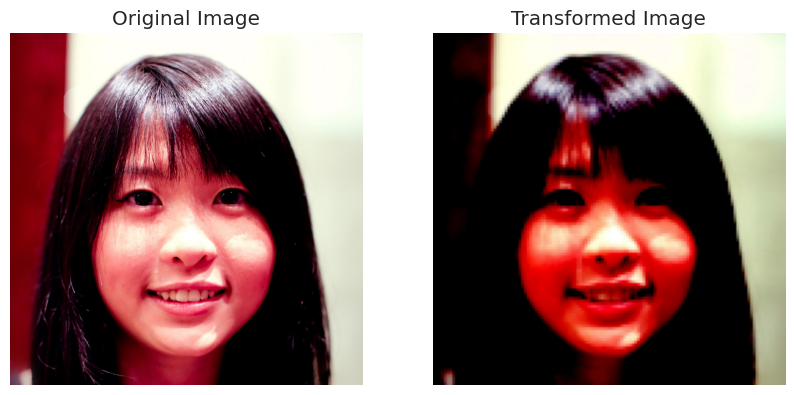

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axes[0].imshow(Image.open(image_files[0]))
axes[0].set_title("Original Image")
axes[0].axis("off")

# Transformed image
axes[1].imshow(transformed_image.permute(1, 2, 0))
axes[1].set_title("Transformed Image")
axes[1].axis("off")